# Redes Sociais - APS 3

### Alunos: Arthur Barreto, Enricco Gemha e Felipe Catapano


Extraindo dados do maior marketplace de jogos da atualidade, *Steam* [$^1$](https://www.kaggle.com/datasets/nikdavis/steam-store-games), construímos uma rede de empresas desenvolvedoras de jogos que se conectam quando produzem jogos do mesmo subgênero, considerando mais de 27.033 jogos, de mais de 17.000 desenvolvedoras. Os vértices representam empresas desenvolvedoras de jogos e uma aresta não-direcionada indica um número de jogos a definir para cada subgênero que ambas produziram.

## Pré-requisitos

In [1]:
import graph_tool_extras as gte
import netpixi
from graph_tool import draw
import distribution as dst
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH = 'steam.csv'

## Análise dos dados importados

Primeiro, abrimos e lemos o arquivo `steam.csv` para entendermos como os dados estão estruturados. 
Isso nos dá um *insight* de como realizar o *parsing* do arquivo e como extrair as informações que precisamos.
Com isso, definimos uma função `get_data` que realiza a subrotina de extração e limpeza de uma linha do arquivo `steam.csv`.

In [3]:
def get_data(line):
    # realiza o split somente nas vírgulas que não estão entre aspas
    line_cleaned = [x.strip('"') for x in line.split(',')]

    # adquire o gênero do jogo (contido em `genres`)
    genre = line_cleaned[9]

    # adquire o gênero do jogo (contido em `owners`)
    try:
        owners = (int(line_cleaned[16].split('-')[1]) + int(line_cleaned[16].split('-')[0])) / 2
    except:
        # ignora a linha pois está fora do padrão
        return 'error', 0, [], True # envia bool de `got_error`

    # adquire o desenvolvedor do jogo (contido em `developer`)
    developer = line_cleaned[4]

    # adquire uma lista de sub-gêneros (todos as tags do `steamspy` separados por ';', exceto o contido em `genres`)
    sub_genres = [x for x in line_cleaned[10].split(';') if x != genre]
    
    return developer, owners, sub_genres, False

Com isso, espiamos a saída da função `get_data` para entendermos como os dados estão estruturados.

In [4]:
with open(PATH) as file:

    # cria index de contagem para o loop abaixo.
    i = 0
    
    # ignora o cabeçalho.
    next(file)

    # Para não sobrecarregar este notebook
    # vamos espiar somente as 5 primeiras linhas.
    for line in file:
        dev, owners, sub_genres, got_error = get_data(line)
        if got_error:
            continue
        print(f'Developer: {dev}\nSubgenres: {sub_genres}\nOwners: {owners}\n')
        
        # Para não sobrecarregar este notebook, vamos usar um contador
        # e um break para imprimir apenas as cinco primeiras linhas.
        i += 1
        if i == 5:
            break

Developer: Valve
Subgenres: ['FPS', 'Multiplayer']
Owners: 15000000.0

Developer: Valve
Subgenres: ['FPS', 'Multiplayer']
Owners: 7500000.0

Developer: Valve
Subgenres: ['FPS', 'World War II', 'Multiplayer']
Owners: 7500000.0

Developer: Valve
Subgenres: ['FPS', 'Multiplayer']
Owners: 7500000.0

Developer: Gearbox Software
Subgenres: ['FPS', 'Sci-fi']
Owners: 7500000.0



## Obtendo o valor de `fator_concorrencia`

Agora que possuímos as informações de `developer`, `owners` e `subgenres` de cada jogo, vamos calcular para cada `developer` o número de vendas (`owners`) somadas de todos os jogos que ela já produziu por `subgenre`. Isso nos ajudará a medir o impacto de cada `developer` em cada `subgenre` e, consequentemente, a concorrência entre `developers` em cada `subgenre`, escolhemos chamar isto de `fator_concorrencia`. 

In [5]:
with open(PATH) as file:

    # armazena quantidade de linhas ignoradas por input incorreto
    parsing_errors = 0
    
    # ignora o cabeçalho.
    next(file)

    # criamos uma variável para armazenar o fator de concorrência de cada empresa.
    game_industry = {}

    for line in file:
        
        # adquire nome do desenvolvedor, quantidade de vendas e sub-gêneros em um jogo (linha).
        dev, owners, sub_genres, got_error = get_data(line)
        if got_error:
            parsing_errors += 1
            continue

    	# cria um dicionário para o developer, caso não exista.
        if game_industry.get(dev) is None:
            game_industry[dev] = {}

        # altera o valor do fato de concorrência para cada sub-gênero, na developer atual.
        for sub_genre in sub_genres:
            game_industry[dev][sub_genre] = game_industry[dev].get(sub_genre, 0) + owners

print(f'Foram detectados {parsing_errors} erros de parsing (linhas ignoradas)!')
print(f'Temos {len(game_industry)} empresas armazenadas.')
print(f'\nPor exemplo, vamos espiar a developer `Valve`:\n{game_industry["Valve"]}')

# imprime a quantidade de sub-gêneros únicos.
all_sub_genres = [x for y in game_industry.values() for x in y.keys()]
print(f'\nTemos {len(set(all_sub_genres))} sub-gêneros únicos.')

Foram detectados 1242 erros de parsing (linhas ignoradas)!
Temos 16388 empresas armazenadas.

Por exemplo, vamos espiar a developer `Valve`:
{'FPS': 218500000.0, 'Multiplayer': 140000000.0, 'World War II': 15000000.0, 'Classic': 7500000.0, 'Sci-fi': 33500000.0, 'Singleplayer': 30000000.0, 'Puzzle': 30000000.0, 'First-Person': 30000000.0, 'Free to Play': 190000000.0, 'Zombies': 22500000.0, 'Co-op': 41000000.0, 'MOBA': 150000000.0, 'Strategy': 150000000.0, 'Animation & Modeling': 1500000.0, 'Video Production': 1500000.0, 'VR': 750000.0, 'Action': 750000.0, 'Card Game': 1500000.0, 'Trading Card Game': 1500000.0}

Temos 337 sub-gêneros únicos.


Agora que posuimos o `fator_concorrencia` de cada `developer` em cada `subgenre`, vamos montar a tabela de distribuição de arestas. Isso nos ajudará a entender qual threshold de `fator_concorrencia` devemos utilizar para definir se duas `developers` estão concorrendo em um `subgenre` ou não.

In [6]:
# Agora que posuimos o `fator_concorrencia` de cada `developer` em cada `subgenre`, vamos montar a tabela de distribuição de arestas. Isso nos ajudará a entender qual threshold de `fator_concorrencia` devemos utilizar para definir se duas `developers` estão concorrendo em um `subgenre` ou não.

# criamos uma lista contendo os cortes de threshold que queremos testar.
# sem threshold | 100 mil | 250 mil | 500 mil | 1 milhão
thresholds = [0, 100000, 250000, 500000, 1000000]

# criamos uma lista para armazenar `game_industry` depois de aplicado o threshold.
game_industry_thresholded = [{}, {}, {}, {}, {}]

# varremos a `game_industry` e criamos uma versão dela para cada threshold.
for i in range(len(thresholds)):
    threshold = thresholds[i]
    
    for dev, sub_genres in game_industry.items():
        for sub_genre, owners in sub_genres.items():
            if owners > threshold:
                game_industry_thresholded[i][dev] = game_industry_thresholded[i].get(dev, {})
                game_industry_thresholded[i][dev][sub_genre] = owners

print(f'Por exemplo, vamos espiar a developer `Valve` sem threshold:\n{game_industry_thresholded[0]["Valve"]}\n')
print(f'Por exemplo, vamos espiar a developer `Valve` com threshold de 100 MIL:\n{game_industry_thresholded[1]["Valve"]}\n')
print(f'Por exemplo, vamos espiar a developer `Valve` com threshold de 250 MIL:\n{game_industry_thresholded[2]["Valve"]}\n')
print(f'Por exemplo, vamos espiar a developer `Valve` com threshold de 500 MIL:\n{game_industry_thresholded[3]["Valve"]}\n')
print(f'Por exemplo, vamos espiar a developer `Valve` com threshold de 1 MILHÃO:\n{game_industry_thresholded[4]["Valve"]}\n')

Por exemplo, vamos espiar a developer `Valve` sem threshold:
{'FPS': 218500000.0, 'Multiplayer': 140000000.0, 'World War II': 15000000.0, 'Classic': 7500000.0, 'Sci-fi': 33500000.0, 'Singleplayer': 30000000.0, 'Puzzle': 30000000.0, 'First-Person': 30000000.0, 'Free to Play': 190000000.0, 'Zombies': 22500000.0, 'Co-op': 41000000.0, 'MOBA': 150000000.0, 'Strategy': 150000000.0, 'Animation & Modeling': 1500000.0, 'Video Production': 1500000.0, 'VR': 750000.0, 'Action': 750000.0, 'Card Game': 1500000.0, 'Trading Card Game': 1500000.0}

Por exemplo, vamos espiar a developer `Valve` com threshold de 100 MIL:
{'FPS': 218500000.0, 'Multiplayer': 140000000.0, 'World War II': 15000000.0, 'Classic': 7500000.0, 'Sci-fi': 33500000.0, 'Singleplayer': 30000000.0, 'Puzzle': 30000000.0, 'First-Person': 30000000.0, 'Free to Play': 190000000.0, 'Zombies': 22500000.0, 'Co-op': 41000000.0, 'MOBA': 150000000.0, 'Strategy': 150000000.0, 'Animation & Modeling': 1500000.0, 'Video Production': 1500000.0, 'VR': 

In [7]:
# cria um dicionário que tem como chave o threshold e como valor um dicionário.
# o dicionário interno tem como chave o sub-gênero e como valor uma lista com todas as empresas que estão concorrendo neste sub-gênero.
edges_for_thresholds = [{}, {}, {}, {}, {}]
for i in range(len(thresholds)):
    for dev, sub_genres in game_industry_thresholded[i].items():
        for sub_genre, owners in sub_genres.items():
            edges_for_thresholds[i][sub_genre] = edges_for_thresholds[i].get(sub_genre, [])
            edges_for_thresholds[i][sub_genre].append(dev)

print(f'Por exemplo, vamos espiar a quantidade de empresas que estão concorrendo no sub-gênero `Action` sem threshold:\n{len(edges_for_thresholds[0]["Action"])}')
print(f'Por exemplo, vamos espiar a quantidade de empresas que estão concorrendo no sub-gênero `Action` com threshold de 100 MIL:\n{len(edges_for_thresholds[1]["Action"])}')
print(f'Por exemplo, vamos espiar a quantidade de empresas que estão concorrendo no sub-gênero `Action` com threshold de 250 MIL:\n{len(edges_for_thresholds[2]["Action"])}')
print(f'Por exemplo, vamos espiar a quantidade de empresas que estão concorrendo no sub-gênero `Action` com threshold de 500 MIL:\n{len(edges_for_thresholds[3]["Action"])}')
print(f'Por exemplo, vamos espiar a quantidade de empresas que estão concorrendo no sub-gênero `Action` com threshold de 1 MILHÃO:\n{len(edges_for_thresholds[4]["Action"])}')

Por exemplo, vamos espiar a quantidade de empresas que estão concorrendo no sub-gênero `Action` sem threshold:
7160
Por exemplo, vamos espiar a quantidade de empresas que estão concorrendo no sub-gênero `Action` com threshold de 100 MIL:
784
Por exemplo, vamos espiar a quantidade de empresas que estão concorrendo no sub-gênero `Action` com threshold de 250 MIL:
443
Por exemplo, vamos espiar a quantidade de empresas que estão concorrendo no sub-gênero `Action` com threshold de 500 MIL:
197
Por exemplo, vamos espiar a quantidade de empresas que estão concorrendo no sub-gênero `Action` com threshold de 1 MILHÃO:
95


Parece estar funcionando! Vamos agora trocar a lista de `developers` por um contador de arestas entre esses `developers`.

In [8]:
# criamos uma função que conta todas as arestas possíveis para uma lista de empresas.
def count_edges(developers):
    edges = 0
    for i in range(len(developers)):
        for j in range(i + 1, len(developers)):
            edges += 1
    return edges

In [9]:
for i in range(len(thresholds)):
    for sub_genre, developers in edges_for_thresholds[i].items():
        edges_for_thresholds[i][sub_genre] = count_edges(developers)

# imprime a quantidade de arestas possíveis, somando todos os sub-gêneros.
print(f'Quantidade de arestas possíveis na rede sem threshold:\n{sum(edges_for_thresholds[0].values())}')
print(f'Quantidade de arestas possíveis na rede com threshold de 100 MIL:\n{sum(edges_for_thresholds[1].values())}')
print(f'Quantidade de arestas possíveis na rede com threshold de 250 MIL:\n{sum(edges_for_thresholds[2].values())}')
print(f'Quantidade de arestas possíveis na rede com threshold de 500 MIL:\n{sum(edges_for_thresholds[3].values())}')
print(f'Quantidade de arestas possíveis na rede com threshold de 1 MILHÃO:\n{sum(edges_for_thresholds[4].values())}')

Quantidade de arestas possíveis na rede sem threshold:
120276307
Quantidade de arestas possíveis na rede com threshold de 100 MIL:
1485862
Quantidade de arestas possíveis na rede com threshold de 250 MIL:
464410
Quantidade de arestas possíveis na rede com threshold de 500 MIL:
94137
Quantidade de arestas possíveis na rede com threshold de 1 MILHÃO:
27766


[Como empresas grandes veêm o sucesso de um jogo em vendas](https://www.capcom.co.jp/ir/english/business/million.html#:~:text=In%20the%20home%20video%20game,Street%20Fighter%20and%20Resident%20Evil.) - 1 milhão de cópias vendidas

[Discussão em fórum sobre o sucesso de um jogo Indie em vendas](https://www.quora.com/How-many-sales-does-a-game-typically-need-to-make-to-be-considered-successful#:~:text=Other%20answers%20have%20mentioned%20that,the%201%2C000%20%2D%202%2C000%20unit%20range!) - 100 a 250 mil cópias vendidas

Determinar se uma empresa de desenvolvimento de jogos é atuante em um sub-gênero com base apenas em dados de jogos já lançados pode ser um desafio, mas estabeleceremos critérios matemáticos que levem em consideração a quantidade de lançamentos e a concentração em um sub-gênero específico. Mas primeiro, vamos entender quais são as *"personas"* de empresas de desenvolvimento de jogos.

- **Indie**: Empresas pequenas, que desenvolvem poucos jogos e de nicho (sub-gêneros parecidos). Exemplos: *Yatch Club Games* (Platformers), *Team Cherry* (Metroidvania).

- **AAA**: Empresas grandes, com muitos funcionários e que desenvolvem muitos jogos e de diferentes sub-gêneros. Exemplos: *Ubisoft*, *Electronic Arts*.

- **Mid-size**: Empresas de tamanho médio, que desenvolvem muitos jogos e de sub-gêneros parecidos. Exemplos: *Square Enix* (RPGs).

Por isso estabelecemos 2 critérios (escolhidos qualitativamente) que definem se determinada empresa de desenvolvimento de jogos é atuante em um sub-gênero:

1. **Porcentagem de Jogos no Sub-Gênero**: Calculamos a porcentagem de jogos de um sub-gênero específico em relação ao número total de jogos lançados pela empresa. Se essa porcentagem for alta (acima de 67%), consideramos que a empresa é concorrente nesse sub-gênero. *Aqui captamos empresas de nicho*, como *Mid-size* e *Indie*.

2. **Número de Jogos que a empresa lançou**: Se uma empresa possui um número muito alto de jogos lançados, ou seja está no quarto quartil em quantidade de jogos lançados, consideramos que ela é uma concorrente em todo sub-gênero que ela lançar jogos. *Aqui captamos empresas de grande porte*, as *AAA*.

Vamos observar como se dá a distribuição de jogos por desenvolvedoras, ignorando o subgênero.

(array([2.4600e+02, 4.6700e+02, 1.7270e+03, 1.0733e+04, 2.4300e+02,
        3.5900e+02, 1.5470e+03, 9.4000e+01, 1.5500e+02, 5.1300e+02,
        6.3000e+01, 6.6000e+01, 1.9700e+02, 3.1000e+01, 4.1000e+01,
        1.0800e+02, 2.0000e+01, 2.7000e+01, 5.5000e+01, 1.4000e+01,
        2.1000e+01, 3.9000e+01, 1.4000e+01, 1.4000e+01, 3.7000e+01,
        6.0000e+00, 8.0000e+00, 1.6000e+01, 1.0000e+00, 9.0000e+00,
        1.2000e+01, 4.0000e+00, 6.0000e+00, 1.2000e+01, 1.0000e+00,
        3.0000e+00, 9.0000e+00, 3.0000e+00, 5.0000e+00, 7.0000e+00,
        2.0000e+00, 5.0000e+00, 5.0000e+00, 0.0000e+00, 1.0000e+00,
        3.0000e+00, 5.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00,
        3.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 7.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.00

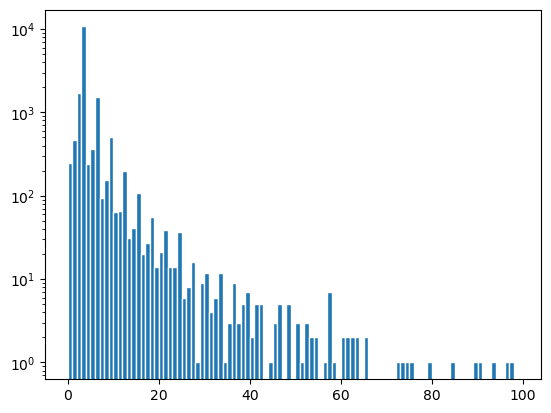

In [21]:
# cria lista para armazenar a quantidade de jogos por desenvolvedora.
lista_jogos = []

# preenche a lista com a quantidade de jogos por desenvolvedora.
for dev, sub_genres in inventory.items():
    lista_jogos.append(sum(sub_genres.values()))

# cria um histograma com a quantidade de jogos por desenvolvedora, indo de 0 a 200.
# limitando os eixos x e y.
plt.hist(lista_jogos, edgecolor='white', bins=range(0, 100), log=True)

((array([4.07493933e-05, 9.89151740e-05, 1.57710404e-04, ...,
         8.75482895e+00, 9.22129736e+00, 1.01080900e+01]),
  array([  0,   0,   0, ..., 239, 279, 386])),
 (4.868456388534919, -0.4814457239387355, 0.6993370574171812))

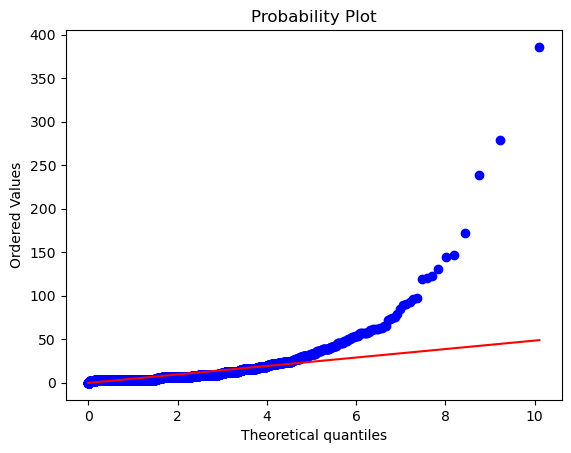

In [24]:
from scipy import stats
lista_proxy_jogos = [x for x in lista_jogos if x < 1000]
stats.probplot(lista_jogos, dist='expon', plot=plt)

Com o gráfico acima podemos concluir que a grande maioria das empresas desenvolvedoras de jogos desenvolvem até 10 jogos, enquanto poucas empresas desenvolvedoras de jogos desenvolvem muitos jogos (30 ou mais).

Vamos ver com quantos subgêneros diferentes as empresas desenvolvedoras de jogos trabalham.

In [7]:
# criamos uma lista para armazenar o nome de cada sub-gênero.
lista_sub_genres = []

# preenchemos a lista com os sub-gêneros.
for dev, sub_genres in inventory.items():
    for sub_genre in sub_genres.keys():
        if sub_genre not in lista_sub_genres:
            lista_sub_genres.append(sub_genre)

print(f'Quantidade de subgêneros existentes: {len(lista_sub_genres)}')

Quantidade de subgêneros existentes: 370


(TODO) Iremos analisar a distribuição dos pesos das arestas para definir um valor mínimo para que uma aresta seja considerada na rede.
Por isso, plotaremos um histograma para cada sub-gênero.

In [ ]:
# criamos um dicionário para armazenar os sub-gêneros e suas frequências.
dict_sub_genres = {}

# preenchemos o dicionário, com chaves de sub-gêneros e valores de lista de empresas atuantes no sub-gênero.
for sub_genre in lista_sub_genres:
    dev_in_sub_genre = []
    for dev, sub_genres in inventory.items():
        if sub_genre in sub_genres.keys():
            dev_in_sub_genre.append(dev)

Com base no resultado da distribuição, decidimos que o peso mínimo para uma aresta ser considerada na rede será de 5 filmes.

## Criação do grafo

Utilizaremos a biblioteca [graph-tool](https://graph-tool.skewed.de/) somente para criação e visualização básica dos grafos, sem suporte de nenhum método ou função que não seja essencial.

In [4]:
g = gte.Graph(directed=False) # pois o grafo não é direcionado, como informado acima.

Antes, vamos definir duas funções auxiliares para facilitar a adição de novos nós e arestas, respectivamente.

In [5]:
def get_or_add_vertex(g, id):
    u = g.vertex_by_id(id)
    if u is None:
        u = g.add_vertex_by_id(id)
    return u

def get_or_add_edge(g, id1, id2):
    e = g.edge_by_ids(id1, id2)
    if e is None:
        e = g.add_edge_by_ids(id1, id2)
    return e

Antes, vamos definir duas funções auxiliares para facilitar a adição de novos nós e arestas, respectivamente.

In [7]:
with open(PATH) as file:

    # cria index de contagem para o loop abaixo.
    i = 1
    
    # ignora o cabeçalho.
    next(file)

    for line in file:

        # os dados são armazenados em:
        # a cada linha, separados por vírgula, temos:
        # cast, crew, id

        # seleciona todo o conteúdo da string entre '[' e ']'
        cast = line.split('[')[1].split(']')[0]

        # cast é uma lista de dicionários
        # cada dicionário tem as chaves:
        # cast_id, character, credit_id, gender, id, name, order, profile_path
        # de cada dicionário, precisamos somente de name
        # seleciona todo o conteúdo entre '{' e '}' e depois a chave 'name'
        names = cast.split("'name': '")
        # seleciona somente com os indices ímpares
        names = names[1::2]
        # seleciona todo o conteúdo até a primeira aspas simples
        names = [name.split("'")[0] for name in names]

        # adiciona os vértices
        for name in names:
            get_or_add_vertex(g, name)

        # adiciona as arestas
        for j in range(len(names)):
            for k in range(j+1, len(names)):
                get_or_add_edge(g, names[j], names[k])
        
        # incrementa contador
        i += 1

# Imprime a quantidade de linhas lidas.
print(f'Foram lidas {i} linhas.') 

Foram lidas 45477 linhas.


A seguir, devemos chamar `draw.sfdp_layout`, passando a rede, para rodar um algoritmo de posicionamento chamado SFDP [[1](#sfdp)].

Esse algoritmo usa uma ideia conhecida como [force-directed graph drawing](https://en.wikipedia.org/wiki/Force-directed_graph_drawing) para posicionar os vértices de forma a evidenciar agrupamentos.

In [8]:
layout = draw.sfdp_layout(g)

In [9]:
gte.move(g, layout)

## Armazenamento da rede

Para garantir a segurança da informação processada, devemos guardá-la em um arquivo na mesma pasta deste notebook.

In [10]:
g = gte.clean(g)
gte.save(g, 'spotify.net.gz')

## Visualização da rede

O próximo passo é a renderização da rede.

In [11]:
r = netpixi.render('spotify.net.gz', infinite=True)

Por fim, devemos ajustar a visualização da renderização.

In [12]:
r.vertex_default(size=4, bwidth=1)

In [13]:
r.edge_default(width=1)